# Train a localized LightGBM model for regression task: predict delay difference focusing a time period in one day only

In [43]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import sklearn
# from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# from sklearn.tree import DecisionTreeRegressor
import numpy as np

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format

In [44]:
import sys
import logging
import datetime

nblog = open("./logs/tree_pdp_shap_"+str(datetime.datetime.now())+".log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [57]:
%%time

df_traffic = pd.read_csv('output/austin_2022_GP_10min_interval_delaydifference_with_features_forML_final.csv')
df_traffic = df_traffic.rename(columns={"miles": "segment_length"})

df_traffic['minutes_since_midnight'] = df_traffic['hour_min'].apply(lambda x: int(x[:2]) * 60 + int(x[3:]))
df_traffic = df_traffic[df_traffic['tmc_code']!='112+53808']  # this is a segment disconnected with every road

print(df_traffic.date.unique())
print('unique road segments (samples):',df_traffic.tmc_code.unique().shape[0])
print('total observations: ',df_traffic.shape[0])

# because the event usually begins in the morning after 10, people arrive typically around that time, so we want to only focus on after 930
# df_traffic = df_traffic[df_traffic['minutes_since_midnight']>=540]
print(df_traffic.shape[0]) #866449
# df_traffic = pd.get_dummies(df_traffic, columns=['date'], prefix='date')

['2022-10-17' '2022-10-18' '2022-10-19' '2022-10-20' '2022-10-21'
 '2022-10-22' '2022-10-23']
unique road segments (samples): 3223
total observations:  3547722
2196629
CPU times: user 9.73 s, sys: 3.69 s, total: 13.4 s
Wall time: 13.4 s


## Merge with graph embeddings of road network

In [58]:
df_road_embeddings = pd.read_csv('output/network_embeddings.csv')
suffixes = [int(col.split('_')[-1]) for col in df_road_embeddings.columns if col.startswith('embedding_')]
max_embeddings = max(suffixes) if suffixes else None
print(max_embeddings)

df_traffic = df_traffic.merge(df_road_embeddings, how='left')
print(df_traffic.shape[0])
df_traffic.head(2)

63
2196629


,tmc_code,hour_min,delay_baseline,delay_focus,delay_difference,date,intersection,start_latitude,start_longitude,end_latitude,end_longitude,segment_length,airbnb_count,distance_to_venue_centroid,distance_to_Shuttle_Waterloo_Park,distance_to_Shuttle_Barton_Creek_Square,distance_to_Shuttle_Expo_Center,segment_bearing,osm_id,road_type,oneway,lanes_mean,maxspeed_value,day_of_week,no_devices,no_devices_baseline,no_devices_focus,demand_diff,minutes_since_midnight,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63
0,112+04760,09:00,-1.06365,-1.30941,-0.24577,2022-10-17,US-183/EXIT 239-240,30.32874,-97.70568,30.33272,-97.70402,0.29287,49,26.64241,7.39988,14.41580,10.33789,19.79829,"[122981397, 1012363973]66847798019339769835",secondary,True,1.50000,55.00000,0,0.00000,132.00000,108.00000,-24.00000,540,0.80788,-0.30878,0.48830,0.40444,-0.19644,-0.63592,-0.05096,-0.96207,-0.26387,0.54659,-1.03205,-0.57319,0.58703,-0.90266,0.39712,0.64467,0.02475,-0.13640,-0.42769,0.39307,0.45515,0.69224,0.02814,-0.87651,-0.46587,-0.28346,-0.03728,-0.89838,-0.87812,-0.60183,0.24631,-0.66729,0.74725,-0.08435,0.21258,0.50216,-0.85987,-0.10462,0.10216,-0.61296,0.70476,-0.07447,-0.44610,-1.25291,-0.56601,0.08196,0.06211,0.14970,0.23362,-0.72179,0.71536,0.29920,-0.47497,-0.78599,-0.12997,-0.19213,-0.19580,-0.42946,-1.18347,0.54779,-0.78096,0.16931,0.24326,-0.44661
1,112+04760,09:00,-1.06365,-1.30941,-0.24577,2022-10-17,US-183/EXIT 239-240,30.32874,-97.70568,30.33272,-97.70402,0.29287,49,26.64241,7.39988,14.41580,10.33789,19.79829,"[122981397, 1012363973]66847798019339769835",secondary,True,1.50000,55.00000,0,0.00000,132.00000,33.00000,-99.00000,540,0.80788,-0.30878,0.48830,0.40444,-0.19644,-0.63592,-0.05096,-0.96207,-0.26387,0.54659,-1.03205,-0.57319,0.58703,-0.90266,0.39712,0.64467,0.02475,-0.13640,-0.42769,0.39307,0.45515,0.69224,0.02814,-0.87651,-0.46587,-0.28346,-0.03728,-0.89838,-0.87812,-0.60183,0.24631,-0.66729,0.74725,-0.08435,0.21258,0.50216,-0.85987,-0.10462,0.10216,-0.61296,0.70476,-0.07447,-0.44610,-1.25291,-0.56601,0.08196,0.06211,0.14970,0.23362,-0.72179,0.71536,0.29920,-0.47497,-0.78599,-0.12997,-0.19213,-0.19580,-0.42946,-1.18347,0.54779,-0.78096,0.16931,0.24326,-0.44661


# Filtering data for ML

In [59]:
_param_day_of_week = 6 # 5: Saturday, 6: Sunday
_param_morning_or_evening = 'evening' # 'morning', 'evening'

print(datetime.datetime.now(),'Day: ',_param_day_of_week,_param_morning_or_evening)

2025-02-27 15:55:59.400474 Day:  6 evening


In [60]:
df_traffic = df_traffic[df_traffic['day_of_week']==_param_day_of_week]
print(df_traffic.shape[0])

# select two focused time period for training a ML model
if _param_morning_or_evening == 'morning':
    df_traffic = df_traffic[(df_traffic['minutes_since_midnight']>=10*60)&(df_traffic['minutes_since_midnight']<=12*60)] 
elif _param_morning_or_evening == 'evening':
    df_traffic = df_traffic[(df_traffic['minutes_since_midnight']>=17*60)&(df_traffic['minutes_since_midnight']<=20*60)] 
print(df_traffic.shape[0])

286669
61199


# Descriptive statistics (optional)

In [6]:
df_traffic.columns

Index(['tmc_code', 'hour_min', 'delay_baseline', 'delay_focus', 'delay_difference', 'date', 'intersection', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'segment_length', 'airbnb_count', 'distance_to_venue_centroid', 'distance_to_Shuttle_Waterloo_Park', 'distance_to_Shuttle_Barton_Creek_Square', 'distance_to_Shuttle_Expo_Center', 'segment_bearing', 'osm_id', 'road_type', 'oneway', 'lanes_mean', 'maxspeed_value', 'day_of_week', 'no_devices', 'no_devices_baseline', 'no_devices_focus', 'demand_diff', 'minutes_since_midnight', 'embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7', 'embedding_8', 'embedding_9', 'embedding_10', 'embedding_11', 'embedding_12', 'embedding_13', 'embedding_14', 'embedding_15', 'embedding_16', 'embedding_17', 'embedding_18', 'embedding_19', 'embedding_20', 'embedding_21', 'embedding_22', 'embedding_23', 'embedding_24', 'embedding_25', 'embedding_26', 'embedding_27',
       '

In [10]:
# df_traffic.max_speed.describe().apply(lambda x: f"{x:.2f}")
# df_traffic.segment_bearing.describe()

In [11]:
# df_traffic['road_type'].value_counts(normalize=True).apply(lambda x: f"{x*100:.2f}").sort_index(ascending=True)

# Preparing training data

In [61]:
# df_test = df_traffic[['minutes_since_midnight',   'segment_length',
#                 'date_2022-10-21', 'date_2022-10-22', 'date_2022-10-23',
#                 'airbnb_count',  'distance_to_venue_centroid', 'oneway', 'lanes_mean','road_type',
#             'distance_to_Shuttle_Waterloo_Park', 
#                ]].copy() 
# df_test_cor = df_test.corr()
# pd.DataFrame(np.linalg.inv(df_test.corr().values), index = df_test_cor.index, columns=df_test_cor.columns)

feature_names = ['minutes_since_midnight', 'segment_length','segment_bearing', 'oneway', 'lanes_mean','road_type', 'maxspeed_value',
                'airbnb_count', 'distance_to_venue_centroid', 'no_devices_baseline', 'no_devices_focus'
               ] #'no_devices', 'day_of_week', 

feature_names.extend([f"embedding_{i}" for i in range(max_embeddings)])

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare input features and labels for the model

X = df_traffic[feature_names].copy() 
# 'distance_to_Shuttle_Waterloo_Park', 'distance_to_Shuttle_Barton_Creek_Square', 'distance_to_Shuttle_Expo_Center',
# 'start_latitude', 'start_longitude',

X['road_type'] = X['road_type'].astype('category')

y = df_traffic['delay_difference'].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Total sample size:', X.shape[0])
print('Total training set size:', X_train.shape[0])
print('Total test set size:', X_test.shape[0])

Total sample size: 61199
Total training set size: 42839
Total test set size: 18360


In [9]:
# %%time
# # check VIF
# df_cor = X.corr()
# pd.DataFrame(np.linalg.inv(X.corr().values), index = df_cor.index, columns=df_cor.columns)

# Hyperparameter tuning using optuna

In [51]:
%%time
## this step took 25min to finish

import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from lightgbm import LGBMRegressor

def objective(trial):
    # Define hyperparameters to optimize
    params = {
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 1e-1, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
    }
    
    # Initialize LGBMRegressor with the suggested hyperparameters
    model = LGBMRegressor(**params, categorical_feature=['road_type'])
    
    # Perform cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    rmse_scorer = make_scorer(mean_squared_error, squared=False)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=rmse_scorer)

    return scores.mean()

# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)

[I 2025-02-27 15:50:36,337] A new study created in memory with name: no-name-6f613ef9-7fa5-4af1-9867-1879e2a72e91


[LightGBM] [Warning] feature_fraction is set=0.6262308656577058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6262308656577058
[LightGBM] [Warning] bagging_fraction is set=0.9477506094264543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477506094264543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6262308656577058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6262308656577058
[LightGBM] [Warning] categorical_feature is set=road_type, categorical_column=5 will be ignored. Current value: categorical_feature=road_type
[LightGBM] [Warning] bagging_fraction is set=0.9477506094264543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477506094264543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise

[W 2025-02-27 15:50:37,918] Trial 0 failed with parameters: {'num_leaves': 81, 'max_depth': 11, 'learning_rate': 0.15022491422965994, 'n_estimators': 116, 'min_child_samples': 88, 'min_child_weight': 0.09249803628134882, 'reg_alpha': 5.984953898566108, 'reg_lambda': 0.7741522836708281, 'feature_fraction': 0.6262308656577058, 'bagging_fraction': 0.9477506094264543, 'bagging_freq': 1} because of the following error: The value nan is not acceptable.
[W 2025-02-27 15:50:37,918] Trial 0 failed with value nan.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[W 2025-02-27 15:50:39,300] Trial 1 failed with parameters: {'num_leaves': 114, 'max_depth': 6, 'learning_rate': 0.062454007073444014, 'n_estimators': 220, 'min_child_samples': 58, 'min_child_weight': 0.09503485170279334, 'reg_alpha': 0.8318660194469529, 'reg_lambda': 5.620669991171297, 'feature_fraction': 0.8024004551567485, 'bagging_fraction': 0.798193611185959, 'bagging_freq': 7} because of the following error: The value nan is not acceptable.
[W 2025-02-27 15:50:39,301] Trial 1 failed with value nan.


[LightGBM] [Warning] feature_fraction is set=0.8024004551567485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8024004551567485
[LightGBM] [Warning] bagging_fraction is set=0.798193611185959, subsample=1.0 will be ignored. Current value: bagging_fraction=0.798193611185959
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9243384655482794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9243384655482794
[LightGBM] [Warning] bagging_fraction is set=0.7425176117062449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7425176117062449
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9243384655482794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9243384655482794
[LightGBM] [Warning] categoric

[W 2025-02-27 15:50:40,912] Trial 2 failed with parameters: {'num_leaves': 120, 'max_depth': 8, 'learning_rate': 0.026639226463257833, 'n_estimators': 201, 'min_child_samples': 56, 'min_child_weight': 0.05955675981281464, 'reg_alpha': 2.859836047558153, 'reg_lambda': 1.3466410578835408, 'feature_fraction': 0.9243384655482794, 'bagging_fraction': 0.7425176117062449, 'bagging_freq': 4} because of the following error: The value nan is not acceptable.
[W 2025-02-27 15:50:40,913] Trial 2 failed with value nan.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[W 2025-02-27 15:50:42,775] Trial 3 failed with parameters: {'num_leaves': 141, 'max_depth': 10, 'learning_rate': 0.013951770605496742, 'n_estimators': 193, 'min_child_samples': 73, 'min_child_weight': 0.007425126019536359, 'reg_alpha': 0.6544753402058345, 'reg_lambda': 6.060824203261296, 'feature_fraction': 0.708778437927529, 'bagging_fraction': 0.7501086587943575, 'bagging_freq': 7} because of the following error: The value nan is not acceptable.
[W 2025-02-27 15:50:42,775] Trial 3 failed with value nan.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[W 2025-02-27 15:50:44,004] Trial 4 failed with parameters: {'num_leaves': 195, 'max_depth': 7, 'learning_rate': 0.035423189464926966, 'n_estimators': 144, 'min_child_samples': 30, 'min_child_weight': 0.0014838513651551592, 'reg_alpha': 9.874918625103438, 'reg_lambda': 0.29906026858057544, 'feature_fraction': 0.9545507679449518, 'bagging_fraction': 0.641641172779738, 'bagging_freq': 5} because of the following error: The value nan is not acceptable.
[W 2025-02-27 15:50:44,005] Trial 4 failed with value nan.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[W 2025-02-27 15:50:46,393] Trial 5 failed with parameters: {'num_leaves': 162, 'max_depth': 6, 'learning_rate': 0.08045470861745335, 'n_estimators': 471, 'min_child_samples': 81, 'min_child_weight': 0.04868043855671777, 'reg_alpha': 5.47781312050117, 'reg_lambda': 9.191466258461315, 'feature_fraction': 0.7366527402299892, 'bagging_fraction': 0.6495794096254515, 'bagging_freq': 4} because of the following error: The value nan is not acceptable.
[W 2025-02-27 15:50:46,394] Trial 5 failed with value nan.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[W 2025-02-27 15:50:50,467] Trial 6 failed with parameters: {'num_leaves': 114, 'max_depth': 9, 'learning_rate': 0.18294515990837326, 'n_estimators': 329, 'min_child_samples': 41, 'min_child_weight': 0.009063030108672153, 'reg_alpha': 5.9940433915042775, 'reg_lambda': 9.321474824810407, 'feature_fraction': 0.7413872642194821, 'bagging_fraction': 0.9640170728426264, 'bagging_freq': 1} because of the following error: The value nan is not acceptable.
[W 2025-02-27 15:50:50,467] Trial 6 failed with value nan.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[W 2025-02-27 15:50:53,447] Trial 7 failed with parameters: {'num_leaves': 128, 'max_depth': 13, 'learning_rate': 0.04888458395431358, 'n_estimators': 225, 'min_child_samples': 51, 'min_child_weight': 0.0027331222367857158, 'reg_alpha': 2.230596577657967, 'reg_lambda': 2.260342995200626, 'feature_fraction': 0.624500734766579, 'bagging_fraction': 0.7797488064055487, 'bagging_freq': 9} because of the following error: The value nan is not acceptable.
[W 2025-02-27 15:50:53,448] Trial 7 failed with value nan.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[W 2025-02-27 15:50:55,466] Trial 8 failed with parameters: {'num_leaves': 187, 'max_depth': 4, 'learning_rate': 0.02254699236064668, 'n_estimators': 464, 'min_child_samples': 27, 'min_child_weight': 0.027154232550823172, 'reg_alpha': 1.9747015242455035, 'reg_lambda': 6.054688509471381, 'feature_fraction': 0.8914190914624667, 'bagging_fraction': 0.8739276328070773, 'bagging_freq': 1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/rongxiang/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<timed exec>", line 34, in objective
  File "/home/rongxiang/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
  File "/home/rongxiang/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 684, in cross_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

KeyboardInterrupt: 

# Training: LightGBM
https://lightgbm.readthedocs.io/en/latest/index.html

In [63]:
%%time
import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm import early_stopping

try:
    print('Best trial:', study.best_trial.params)
    print('Best RMSE:', study.best_trial.value)
    params = study.best_trial.params
except:
    print(datetime.datetime.now(),'************ Optuna did not finish ************')

    if _param_morning_or_evening == 'morning':
        params = {'num_leaves': 62, 'max_depth': 10, 'learning_rate': 0.128280845076846, 'n_estimators': 500, 'min_child_samples': 10, 
                  'min_child_weight': 0.0933941844954067, 'reg_alpha': 7.658566861094483, 'reg_lambda': 3.498814281915722, 
                  'feature_fraction': 0.9344872179963994, 'bagging_fraction': 0.925544543512356, 'bagging_freq': 3}
    elif _param_morning_or_evening == 'evening':
        params = {'num_leaves': 145, 'max_depth': 17, 'learning_rate': 0.04997164418446007, 'n_estimators': 330, 'min_child_samples': 10,
                  'min_child_weight': 0.0174172684413271, 'lambda_l1': 0.919513128729248, 'lambda_l2': 1.5758475312005116,
                  'feature_fraction': 0.7788744249702235, 'bagging_fraction': 0.9219048697670043, 'bagging_freq': 3}
    print(params)

model = LGBMRegressor(**params, categorical_feature=['road_type'])
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=50, verbose=True)] 
)

2025-02-27 15:56:20.615758 ************ Optuna did not finish ************
{'num_leaves': 145, 'max_depth': 17, 'learning_rate': 0.04997164418446007, 'n_estimators': 330, 'min_child_samples': 10, 'min_child_weight': 0.0174172684413271, 'lambda_l1': 0.919513128729248, 'lambda_l2': 1.5758475312005116, 'feature_fraction': 0.7788744249702235, 'bagging_fraction': 0.9219048697670043, 'bagging_freq': 3}
[LightGBM] [Warning] feature_fraction is set=0.7788744249702235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7788744249702235
[LightGBM] [Warning] lambda_l2 is set=1.5758475312005116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5758475312005116
[LightGBM] [Warning] lambda_l1 is set=0.919513128729248, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.919513128729248
[LightGBM] [Warning] bagging_fraction is set=0.9219048697670043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9219048697670043
[LightGBM] [Warning] bagging_freq 

LGBMRegressor(bagging_fraction=0.9219048697670043, bagging_freq=3,
              categorical_feature=['road_type'],
              feature_fraction=0.7788744249702235, lambda_l1=0.919513128729248,
              lambda_l2=1.5758475312005116, learning_rate=0.04997164418446007,
              max_depth=17, min_child_samples=10,
              min_child_weight=0.0174172684413271, n_estimators=330,
              num_leaves=145)

In [64]:
import joblib

output_path = './output/day_' + str(_param_day_of_week) + _param_morning_or_evening + '_lightgbm_' + str(datetime.datetime.now()) + '.pkl'
joblib.dump(model, output_path)

['./output/day_6evening_lightgbm_2025-02-27 15:56:30.980745.pkl']

# Model evaluation

In [11]:
%%time 
import lightgbm as lgb
import joblib

# Load the model back

output_path = './output/lightgbm_model_xxx.pkl'
model = joblib.load(output_path)
print("Model loaded successfully!")
# print(model.feature_name_)

Model loaded successfully!
CPU times: user 838 ms, sys: 75.2 ms, total: 913 ms
Wall time: 3.75 s


In [65]:
%%time

import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(datetime.datetime.now(),'Best Model RMSE: %.3f' % rmse)

r2 = r2_score(y_test, y_pred)
print(datetime.datetime.now(),'Best Model R-squared: %.3f' % r2) 
# 0.479

[LightGBM] [Warning] feature_fraction is set=0.7788744249702235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7788744249702235
[LightGBM] [Warning] lambda_l2 is set=1.5758475312005116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5758475312005116
[LightGBM] [Warning] lambda_l1 is set=0.919513128729248, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.919513128729248
[LightGBM] [Warning] bagging_fraction is set=0.9219048697670043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9219048697670043
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
2025-02-27 15:56:35.141868 Best Model RMSE: 11.484
2025-02-27 15:56:35.142504 Best Model R-squared: 0.739
CPU times: user 1.13 s, sys: 2.67 ms, total: 1.13 s
Wall time: 94.7 ms


# SHAP

In [15]:
# import gc
# del df_traffic;gc.collect()

22

In [57]:
%%time
# 47min 25s
import shap

print(datetime.datetime.now(),'*************** Start running SHAP ***************')
explainer = shap.TreeExplainer(model)
shap_values = explainer(X) # this line takes very long time

2025-02-13 11:17:37.085178 *************** Start running SHAP ***************
CPU times: user 2min 53s, sys: 46.9 ms, total: 2min 53s
Wall time: 13.7 s


In [58]:
print(len(shap_values.values))
print(df_traffic.shape[0])

41873
41873


(Optional) save shap values for each observation (this takes 1min)

In [59]:
# %%time
# shaplist = ['shap_'+i for i in X.columns]
# df_shape_values = pd.DataFrame(shap_values.values, columns=shaplist)

# df_shape_values['tmc_code'] = df_traffic['tmc_code'].values
# df_shape_values['minutes_since_midnight'] = df_traffic['minutes_since_midnight'].values

# first_column = df_shape_values.pop('tmc_code')
# df_shape_values.insert(0, 'tmc_code', first_column)

# current_date = datetime.datetime.now().strftime('%Y-%m-%d')
# df_shape_values.to_csv(f'./output/shap_values_{current_date}.csv',sep=',',index=False)
# df_shape_values.head()

In [28]:
# print(df_traffic.shape[0])
# print(df_shape_values.shape[0])

# feature_groups = {
    # 'node_embeddings': [f"embedding_{i}" for i in range(64)]
# }
# for group_name, features in feature_groups.items():
    # print(features)

In [60]:
%%time
feature_groups = {
    'node_embeddings': [f"embedding_{i}" for i in range(max_embeddings)]
}

# Compute absolute mean SHAP values
shap_importance = shap_values.abs.mean(0).values
feature_names = np.array(X.columns)

# Create a dictionary to store combined feature importances
combined_importance = {}

# Sum SHAP values for grouped features
for group_name, features in feature_groups.items():
    combined_importance[group_name] = sum(shap_importance[np.isin(feature_names, features)])

# Keep individual feature importances for features not in any group
for i, name in enumerate(feature_names):
    if name not in np.concatenate(list(feature_groups.values())):
        combined_importance[name] = shap_importance[i]

print(combined_importance)

{'node_embeddings': 8.274938426520599, 'minutes_since_midnight': 0.8599182607321093, 'segment_length': 0.5459340555172326, 'segment_bearing': 0.2575858711936301, 'oneway': 0.023603011478571728, 'lanes_mean': 0.0618496389864221, 'road_type': 0.0478346471529913, 'maxspeed_value': 0.06382981204036212, 'airbnb_count': 0.22937677357275787, 'distance_to_venue_centroid': 0.7374780597230565, 'no_devices_baseline': 0.7954540832324405, 'no_devices_focus': 0.6242339363459609}
CPU times: user 1.23 s, sys: 0 ns, total: 1.23 s
Wall time: 1.23 s


2025-02-13 11:17:56.303688 *************** Start running SHAP importance ***************
CPU times: user 215 ms, sys: 104 ms, total: 320 ms
Wall time: 155 ms


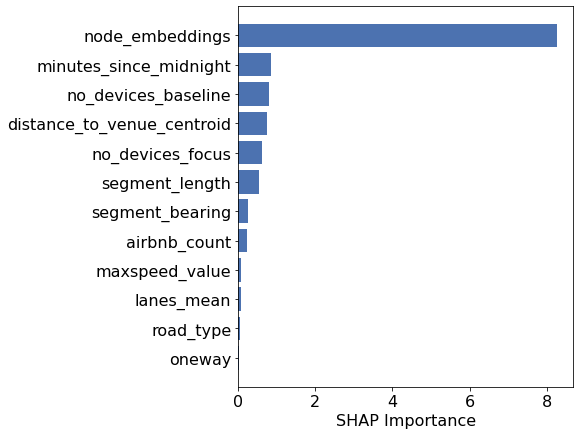

In [61]:
%%time
print(datetime.datetime.now(),'*************** Start running SHAP importance ***************')
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1,figsize=(6,7))

# Sort features by importance (descending order)
sorted_features = sorted(combined_importance.items(), key=lambda x: x[1], reverse=True)

# Extract sorted feature names and values
feature_names_sorted, feature_values_sorted = zip(*sorted_features)

# Plot sorted feature importances
plt.barh(range(len(feature_names_sorted)), feature_values_sorted, align='center', color="#4c72b0")
plt.yticks(range(len(feature_names_sorted)), feature_names_sorted)
plt.xlabel('SHAP Importance')
# plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Ensure the most important feature is at the top
plt.savefig('./output/feature_importance_shap_'+ str(_param_day_of_week) + _param_morning_or_evening + '.pdf', bbox_inches='tight')
# plt.show()

# shap_importance = shap_values.abs.mean(0).values
# sorted_idx = shap_importance.argsort()
# plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center',color="#4c72b0") #'turquoise'
# plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
# plt.xlabel('SHAP Importance')
# plt.savefig('./output/feature_importance_shap.pdf', bbox_inches='tight')

# PDP (Optional)
(may need to skip bc lightgbm seems not support PartialDependenceDisplay of categorical feature)

In [176]:
# feature_list_continuous= ['minutes_since_midnight','airbnb_count',
#                           'distance_to_Shuttle_Waterloo_Park', 'distance_to_Shuttle_Barton_Creek_Square', 
#                           'distance_to_Shuttle_Expo_Center',  'distance_to_venue'
#                           ]
# print('number of continuous features:',len(feature_list_continuous))
# # feature_list_cat = []

In [177]:
# %%time 
# from sklearn.inspection import PartialDependenceDisplay
# # ~5min per PDP graph
# # using for loop, otherwise might occur memory errors
# # PDP for continuous features and save the graph for each feature separately
# print(datetime.datetime.now(),'*************** Start running PDP: feature_list_continuous ***************')

# for feature_one in feature_list_continuous:
#     print(datetime.datetime.now(), feature_one)
#     plt.rcParams.update({'font.size': 14})
#     fig, ax = plt.subplots(figsize=(5,5))
#     pdp_one = PartialDependenceDisplay.from_estimator(model, X, [feature_one],n_jobs = 6, ax=ax)
#     plt.savefig('./output/pdp_' + feature_one + '.pdf', bbox_inches="tight")
# #     break
    
# print(datetime.datetime.now(),'*************** Done running PDP: feature_list_continuous ***************')

In [178]:
# %%time
# # # PDP for categorical variable
# # fig, ax = plt.subplots(figsize=(10, 6))
# # PartialDependenceDisplay.from_estimator(model, X, ['road_type'], categorical_features=['road_type'], n_jobs=6, ax=ax)
# # plt.show()

# # plt.rcParams.update({'font.size': 14})
# # fig, ax = plt.subplots(figsize=(5,5))
# # PartialDependenceDisplay.from_estimator(model, X, ['road_type'], categorical_features=['road_type'], n_jobs=6, ax=ax)
# # pdp1 = PartialDependenceDisplay.from_estimator(model, X, [feature_one], n_jobs=6 , ax=ax)
# # plt.savefig('./output/pdp_'+feature_one+'.pdf',bbox_inches="tight")

# Optional further SHAP analysis

2024-12-13 12:09:42.617856 *************** Start running beeswarm ***************
CPU times: user 1min 31s, sys: 0 ns, total: 1min 31s
Wall time: 1min 29s


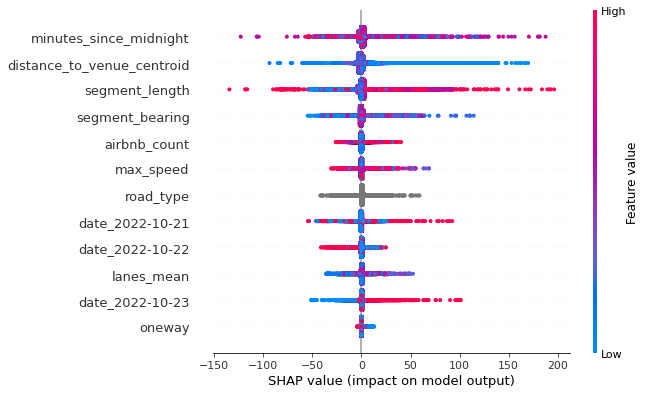

In [63]:
%%time
# ~6min
# Reading about gray colors: https://mlconference.ai/blog/tutorial-explainable-machine-learning-with-python-and-shap/
print(datetime.datetime.now(),'*************** Start running beeswarm ***************')
fig_beeswarm = shap.plots.beeswarm(shap_values,show=False, max_display=50)
plt.savefig('./output/shap_beeswarm.pdf', bbox_inches='tight')

In [64]:
X.columns

Index(['minutes_since_midnight', 'segment_length', 'segment_bearing', 'oneway', 'lanes_mean', 'road_type', 'max_speed', 'date_2022-10-21', 'date_2022-10-22', 'date_2022-10-23', 'airbnb_count', 'distance_to_venue_centroid'], dtype='object')

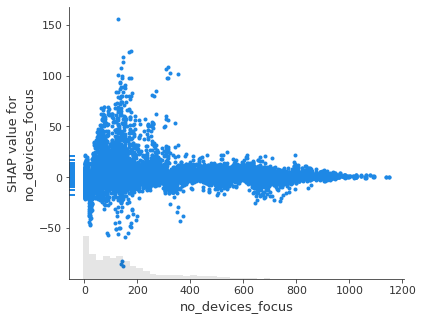

CPU times: user 1min 19s, sys: 196 ms, total: 1min 20s
Wall time: 1min 20s


In [39]:
%%time
shap.plots.scatter(shap_values[:, "no_devices_focus"])

In [ ]:
shap.dependence_plot('distance_to_venue_centroid', shap_values.values, X, dot_size=10, alpha=0.5,
                               interaction_index='no_devices_focus', show=False)

In [ ]:
# Documentation: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/scatter.html
shap.plots.scatter(shap_values[:, "distance_to_venue_centroid"])  #check distance_to_venue_centroid

In [ ]:
# shap.plots.scatter(shap_values[:, "minutes_since_midnight"])
shap.dependence_plot('minutes_since_midnight', shap_values.values, X, dot_size=10, alpha=0.5,
                               interaction_index='distance_to_venue_centroid', show=False)

In [89]:
%%time
shap.plots.scatter(shap_values[:, "airbnb_count"])
# shap.dependence_plot('airbnb_count', shap_values.values, X, dot_size=10, alpha=0.5,
#                                interaction_index='distance_to_venue_centroid', show=False)

In [88]:
shap.plots.scatter(shap_values[:, "segment_bearing"])

In [87]:
shap.plots.scatter(shap_values[:, "segment_length"])

In [86]:
shap.plots.scatter(shap_values[:, "lanes_mean"])

In [85]:
shap.plots.scatter(shap_values[:, "max_speed"])

In [83]:
shap.dependence_plot('road_type', shap_values.values, X, dot_size=5, alpha=0.4,
                               interaction_index='distance_to_venue_centroid', show=False, x_jitter=0.5)

In [126]:
# shap.plots.scatter(shap_values[:, "road_type"])

In [84]:
shap.dependence_plot('oneway', shap_values.values, X, dot_size=5, alpha=0.4,
                               interaction_index='distance_to_venue_centroid', show=False, x_jitter=0.5)

## Spatial SHAP

In [75]:
df_shap_merged = df_traffic.merge(df_shape_values, ) #on=['tmc_code', 'minutes_since_midnight', 'date_2022-10-21','date_2022-10-22','date_2022-10-23']
print(df_shap_merged.shape[0])
df_shap_merged.head()

866449


,tmc_code,hour_min,delay_baseline,delay_focus,delay_difference,intersection,start_latitude,start_longitude,end_latitude,end_longitude,segment_length,airbnb_count,distance_to_venue_centroid,distance_to_Shuttle_Waterloo_Park,distance_to_Shuttle_Barton_Creek_Square,distance_to_Shuttle_Expo_Center,segment_bearing,osm_id,road_type,oneway,lanes,maxspeed,lanes_mean,minutes_since_midnight,date_2022-10-21,date_2022-10-22,date_2022-10-23,max_speed,shap_minutes_since_midnight,shap_segment_length,shap_segment_bearing,shap_oneway,shap_lanes_mean,shap_road_type,shap_max_speed,shap_date_2022-10-21,shap_date_2022-10-22,shap_date_2022-10-23,shap_airbnb_count,shap_distance_to_venue_centroid
0,112+04760,09:00,-1.30941,-0.54871,0.76071,US-183/EXIT 239-240,30.32874,-97.70568,30.33272,-97.70402,0.29287,49,26.64241,7.39988,14.41580,10.33789,19.79829,"[122981397, 1012363973]66847798019339769835",secondary,True,"['1', '2']",55 mph,1.50000,540,1,0,0,55.00000,-0.21827,-0.96356,-0.45418,-0.01172,-0.09461,0.34925,0.33935,0.45318,0.08170,0.01048,-0.16211,-0.77516
1,112+04760,09:10,0.00000,-1.77926,-1.77926,US-183/EXIT 239-240,30.32874,-97.70568,30.33272,-97.70402,0.29287,49,26.64241,7.39988,14.41580,10.33789,19.79829,"[122981397, 1012363973]66847798019339769835",secondary,True,"['1', '2']",55 mph,1.50000,550,1,0,0,55.00000,-0.16006,-0.45093,-0.28606,-0.03561,-0.00280,0.21872,0.33367,0.37435,0.05931,0.01031,0.07095,-0.60821
2,112+04760,09:20,-0.54871,-1.77926,-1.23055,US-183/EXIT 239-240,30.32874,-97.70568,30.33272,-97.70402,0.29287,49,26.64241,7.39988,14.41580,10.33789,19.79829,"[122981397, 1012363973]66847798019339769835",secondary,True,"['1', '2']",55 mph,1.50000,560,1,0,0,55.00000,-0.30254,-0.28288,-0.21448,-0.03393,-0.11840,0.07802,0.36938,0.29424,0.04249,-0.00366,0.06425,-0.56602
3,112+04760,09:30,-1.77926,-1.77926,0.00000,US-183/EXIT 239-240,30.32874,-97.70568,30.33272,-97.70402,0.29287,49,26.64241,7.39988,14.41580,10.33789,19.79829,"[122981397, 1012363973]66847798019339769835",secondary,True,"['1', '2']",55 mph,1.50000,570,1,0,0,55.00000,-0.56381,-0.11521,-0.14709,-0.08472,0.01748,0.03209,0.43572,0.17208,-0.06494,-0.01464,-0.01100,-0.41267
4,112+04760,09:40,-1.54784,0.00000,1.54784,US-183/EXIT 239-240,30.32874,-97.70568,30.33272,-97.70402,0.29287,49,26.64241,7.39988,14.41580,10.33789,19.79829,"[122981397, 1012363973]66847798019339769835",secondary,True,"['1', '2']",55 mph,1.50000,580,1,0,0,55.00000,-0.38371,-0.29069,0.05774,-0.05090,0.15939,0.08098,0.42084,0.10329,0.08977,-0.03089,-0.14186,-0.48977


In [76]:
print('average prediction:', df_shap_merged.shap_minutes_since_midnight.mean())

average prediction: -0.003870122198600434


In [77]:
# Create a polygon for event venue
from shapely.geometry import Polygon
import geopandas as gpd

lat_point_list = [30.131962, 30.146337, 30.140386, 30.122629]
lon_point_list = [-97.647388, -97.635686, -97.619652, -97.631465]
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])       
polygon['name']  = 'the Circuit of the Americas'
polygon
# polygon.explore()

import shapely.geometry as geom

# Create Shapely point geometries
point_waterloo_park = geom.Point(-97.736285, 30.273726) # (longitude, latitude)
point_barton_creek_square = geom.Point(-97.805046, 30.257509)
point_expo_center = geom.Point(-97.622544, 30.297062)
point_ridehailing = geom.Point(-97.614135, 30.178718)

point_shuttle_list = [point_waterloo_park,point_barton_creek_square,point_expo_center,point_ridehailing]
gdf_shuttle = gpd.GeoDataFrame({'Shuttle_Location': ['Shuttle_Waterloo_Park', 'Shuttle_Barton_Creek_Square', 'Shuttle_Expo_Center', 'Uber_DelValle_HighSchool'],
                        'geometry': point_shuttle_list},
                        crs="EPSG:4326")
# gdf_shuttle

In [78]:
df_road = pd.read_csv("data/TMC_Identification.csv", sep=',', header=0)
df_road = df_road[['tmc_code','intersection','start_latitude','start_longitude','end_latitude','end_longitude','miles']]

from shapely.geometry import LineString
from geopandas import GeoDataFrame

df_road['geometry'] = df_road.apply(
    lambda row: LineString([(row['start_longitude'], row['start_latitude']),
                             (row['end_longitude'], row['end_latitude'])]),
    axis=1
)

# Create a GeoDataFrame
gdf_road = GeoDataFrame(df_road, geometry='geometry',crs="EPSG:4326")
print(gdf_road.shape[0])

4460


In [109]:
# Select one time point and plot the SHAP values of several features at that specfic time point
# hourmin_select, date_select = 600, 'date_2022-10-22' #1200
hourmin_select, date_select = 1200, 'date_2022-10-22' #1200
df_plotshap = df_shap_merged[(df_shap_merged['minutes_since_midnight'] == hourmin_select)&(df_shap_merged[date_select] == 1)]
# df_plotshap['shap_coordinates'] = df_plotshap['shap_start_latitude'] + df_plotshap['shap_start_longitude']
print(df_plotshap.shape[0])
print(gdf_road.shape[0])

gdf_road_merged = gdf_road.merge(df_plotshap,) #left_on='tmc', right_on='tmc_code'
print(gdf_road_merged.shape[0])
# gdf_road_merged.shap_coordinates.describe()

3221
4460
3098


In [110]:
gdf_road_merged.columns

Index(['tmc_code', 'intersection', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'miles', 'geometry', 'hour_min', 'delay_baseline', 'delay_focus', 'delay_difference', 'segment_length', 'airbnb_count', 'distance_to_venue_centroid', 'distance_to_Shuttle_Waterloo_Park', 'distance_to_Shuttle_Barton_Creek_Square', 'distance_to_Shuttle_Expo_Center', 'segment_bearing', 'osm_id', 'road_type', 'oneway', 'lanes', 'maxspeed', 'lanes_mean', 'minutes_since_midnight', 'date_2022-10-21', 'date_2022-10-22', 'date_2022-10-23', 'max_speed', 'shap_minutes_since_midnight', 'shap_segment_length', 'shap_segment_bearing', 'shap_oneway', 'shap_lanes_mean', 'shap_road_type', 'shap_max_speed', 'shap_date_2022-10-21', 'shap_date_2022-10-22', 'shap_date_2022-10-23', 'shap_airbnb_count', 'shap_distance_to_venue_centroid'], dtype='object')

In [90]:
%%time
# 'shap_minutes_since_midnight', 'shap_segment_length', 'shap_segment_bearing', 'shap_oneway', 'shap_lanes_mean', 'shap_road_type', 
# 'shap_max_speed', 'shap_date_2022-10-21', 'shap_date_2022-10-22', 'shap_date_2022-10-23', 'shap_airbnb_count', 'shap_distance_to_venue_centroid'
# congestion_colors = ["#00FF00", "#ADFF2F", "#FFFF00", "#FFA500", "#FF0000", "#8B0000"]
shap_select = 'shap_oneway'
print('date:', date_select)
print('hour',hourmin_select/60)
print(shap_select)
m = gdf_road_merged.explore(
    column=shap_select,
    cmap= 'rainbow',
    tiles="CartoDB Positron", # OpenStreetMap, CartoDB dark_matter, CartoDB Positron
    categorical=False
)

m = gdf_shuttle.explore(
    m=m,
    markersize=40,
    linewidth=2,
    edgecolor="black",
)

polygon.explore(
    m=m
)